In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt

# Import and Concatenate Data

## EEG/EMG Data

In [49]:
subject_list = ["m292", "m294"]

In [50]:
def import_and_concatenate_time_series_datasets(subject_list):
    # TODO add comments

    subject_feature_dfs = {}

    # Create list of labels for all subjects

    for subject_idx, subject in enumerate(subject_list):
    
        subject_feature_dfs[subject] = pd.DataFrame()

        single_data_frames = {}
    
        for data_type in ["EEG", "EMG"]:
            
            single_data_frames[data_type] = []
            
            # Import feature datasets
            single_data_frames[data_type].append(pd.read_csv("Time_Series/Features/"+str(subject)+"/"+str(data_type)+"/Topological_Summary_Statistics.csv"))
            single_data_frames[data_type].append(pd.read_csv("Time_Series/Features/"+str(subject)+"/"+str(data_type)+"/Signature_Statistics.csv"))
            single_data_frames[data_type].append(pd.read_csv("Time_Series/Features/"+str(subject)+"/"+str(data_type)+"/Advanced_Features.csv"))


            for df_idx, _ in enumerate(single_data_frames[data_type]):
                    #single_data_frames[data_type][df_idx].drop(columns = ["Label"], inplace = True)
                    single_data_frames[data_type][df_idx].drop(single_data_frames[data_type][df_idx].columns[single_data_frames[data_type][df_idx].columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)


        single_data_frames_both_datatypes = []

            
        for df_idx, _ in enumerate(single_data_frames["EEG"]):

            df_both_data_types = pd.DataFrame()
            
            for data_type in ["EEG", "EMG"]:
                df_both_data_types = pd.concat([df_both_data_types, single_data_frames[data_type][df_idx]], axis=1)


            # Concatenate dataframe to main dataframe
            if len(subject_feature_dfs[subject].index > 0):
                subject_feature_dfs[subject] = pd.concat([subject_feature_dfs[subject], df_both_data_types], axis=1)
            else:
                subject_feature_dfs[subject] = pd.concat([subject_feature_dfs[subject], df_both_data_types], ignore_index=True)
                subject_feature_dfs[subject].drop(subject_feature_dfs[subject].columns[subject_feature_dfs[subject].columns.str.contains('_left',case = False)], axis = 1, inplace = True)

        
        subject_feature_dfs[subject]["Subject"] = subject_idx



    feature_df = pd.concat([subject_feature_dfs["m292"], subject_feature_dfs["m294"]], ignore_index=True)
    

    all_labels = list(feature_df["Label"].iloc[:, 0])
    feature_df.drop(columns = ["Label"], inplace = True)
        
    return feature_df, all_labels

time_series_feature_df, all_labels = import_and_concatenate_time_series_datasets(subject_list)

## Brain Imaging

In [51]:
def load_subject_feature_dfs(subjects):
    """
    Load feature DataFrames for specified subjects.
    
    Args:
    - subjects (list): List of subject names.
    
    Returns:
    - dict: Dictionary containing subject feature DataFrames.
    - list: List of all labels across subjects.
    """
    subject_feature_dfs = {}
    all_labels = []

    for subject in subjects:
        subject_feature_dfs[subject] = pd.DataFrame()
        single_data_frames = []

        single_data_frames.append(pd.read_csv("Brain_Imaging/Features/"+str(subject)+"/Topological_Summary_Statistics.csv"))
        single_data_frames.append(pd.read_csv("Brain_Imaging/Features/"+str(subject)+"/Advanced_Features.csv"))
        single_data_frames.append(pd.read_csv("Brain_Imaging/Features/"+str(subject)+"/Signature_Statistics.csv"))

        for df_idx, df in enumerate(single_data_frames):
            df.drop(df.columns[df.columns.str.contains('unnamed',case=False)], axis=1, inplace=True)

            if len(subject_feature_dfs[subject].index) > 0:
                subject_feature_dfs[subject] = pd.concat([subject_feature_dfs[subject], df], axis=1)
            else:
                subject_feature_dfs[subject] = pd.concat([subject_feature_dfs[subject], df], ignore_index=True)
                subject_feature_dfs[subject].drop(subject_feature_dfs[subject].columns[subject_feature_dfs[subject].columns.str.contains('_left',case=False)], axis=1, inplace=True)

        for label in [0, 1, 2, 3, 4]:
            subject_feature_dfs[subject] = subject_feature_dfs[subject].drop(subject_feature_dfs[subject][subject_feature_dfs[subject]["Label"].iloc[:, 0]==label].index[-1])

        subject_feature_dfs[subject]["Subject"] = subjects.index(subject)

        all_labels.extend(list(subject_feature_dfs[subject]["Label"].iloc[:, 0]))

    brain_imaging_feature_df = pd.concat([subject_feature_dfs[subject] for subject in subjects], ignore_index=True)
    brain_imaging_feature_df.drop(columns=["Label"], inplace=True)

    return subject_feature_dfs, all_labels, brain_imaging_feature_df

subject_feature_dfs, all_labels, brain_imaging_feature_df = load_subject_feature_dfs(subject_list)


In [52]:
def merge_feature_dfs(time_series_feature_df, brain_imaging_feature_df):
    """
    Merge time series and brain imaging feature DataFrames.
    
    Args:
    - time_series_feature_df (pandas.DataFrame): DataFrame containing time series features.
    - brain_imaging_feature_df (pandas.DataFrame): DataFrame containing brain imaging features.
    
    Returns:
    - pandas.DataFrame: Merged DataFrame containing both time series and brain imaging features.
    """
    feature_df = pd.merge(time_series_feature_df, brain_imaging_feature_df, left_index=True, right_index=True, suffixes=('_TS', '_BI'))
    feature_df.reset_index(inplace=True)
    feature_df.drop(columns=["index"], inplace=True)
    return feature_df

merged_feature_df = merge_feature_dfs(time_series_feature_df, brain_imaging_feature_df)

# Cross Validation

In [53]:
def load_indices_all_subjects(subject_list):
    """
    Load train, validation, and test set indices for all subjects.
    
    Args:
    - subject_list (list): List of subject names.
    
    Returns:
    - dict: Dictionary containing train indices for all subjects.
    - dict: Dictionary containing validation indices for all subjects.
    - dict: Dictionary containing test indices for all subjects.
    """
    train_indices_dict_all_subjects = {}
    validation_indices_dict_all_subjects = {}
    test_indices_dict_all_subjects = {}

    for subject in subject_list:
        # Train indices
        train_indices_dict_all_subjects[subject] = np.load("Time_Series/Train_Test_Splitting/"+str(subject)+"/Train_Indices_All_Labels_All_Folds.npy", allow_pickle=True).item()

        # Validation indices
        validation_indices_dict_all_subjects[subject] = np.load("Time_Series/Train_Test_Splitting/"+str(subject)+"/Validation_Indices_All_Labels_All_Folds.npy", allow_pickle=True).item()

        # Final Test set indices
        test_indices_dict_all_subjects[subject] = np.load("Time_Series/Train_Test_Splitting/"+str(subject)+"/Final_Test_Set_Indices_All_Labels.npy", allow_pickle=True).item()

    return train_indices_dict_all_subjects, validation_indices_dict_all_subjects, test_indices_dict_all_subjects

train_indices, validation_indices, test_indices = load_indices_all_subjects(subject_list)


In [54]:
def filter_dataframe_with_indices(feature_df, all_labels, indices_dict_all_subjects):
    """
    indices_dict_all_subjects: Dictionary. Structure {subject: {label: {fold: indices list}}}.
    The indices list is a list of indices within each "label" dataframe (for each subject). If there are
    71 segments of each label (for a subject), then the indices list would be a subset of range(0, 71).
    """

    features_dfs_all_folds = {}
    labels_all_folds = {}

    # Initialize dictionarys with folds as keys and the train/validation sets/ their labels as values
    subject = list(indices_dict_all_subjects.keys())[0]
    for fold, fold_key in enumerate(indices_dict_all_subjects[subject][list(indices_dict_all_subjects[subject].keys())[0]]):
        features_dfs_all_folds[fold_key] = pd.DataFrame()
        labels_all_folds[fold_key] = []

    
    for subject_idx, subject in enumerate(indices_dict_all_subjects.keys()):

        # dictionarys with folds as labels and the train/validation sets/ their labels as values 
        labels_with_set_indices = {}
        features_dfs_for_subject = {}

        filtered_subject_df = feature_df[feature_df["Subject_BI"] == subject_idx]

        indices_filtered_subject_df = filtered_subject_df.index # Save indices for labels
        labels_for_subject = [all_labels[idx] for idx in indices_filtered_subject_df]
        
        filtered_subject_df = filtered_subject_df.reset_index()


        for fold, fold_key in enumerate(indices_dict_all_subjects[subject][list(indices_dict_all_subjects[subject].keys())[0]]):
            
            features_dfs_for_subject[fold_key] = pd.DataFrame()
            labels_with_set_indices[fold_key] = []

        

        for label, label_key in enumerate(train_indices_dict_all_subjects[subject].keys()):

            indices_of_label_within_subject_dataframe = [index for index, value in enumerate(labels_for_subject) if value == label]


            filtered_label_df = filtered_subject_df.loc[indices_of_label_within_subject_dataframe]

            #filtered_label_df.drop(columns = ["level_0"], inplace = True)

            filtered_label_df = filtered_label_df.reset_index()


            for fold, fold_key in enumerate(indices_dict_all_subjects[subject][label_key].keys()):

                set_indices_in_filtered_df = indices_dict_all_subjects[subject][label_key][fold_key]


                feature_df_with_set_indices = filtered_label_df.loc[set_indices_in_filtered_df]

                labels_with_set_indices[fold_key].extend([label]*len(feature_df_with_set_indices.index))
                
        
                features_dfs_for_subject[fold_key] = pd.concat([features_dfs_for_subject[fold_key], feature_df_with_set_indices], ignore_index=True)

        
        for fold, fold_key in enumerate(indices_dict_all_subjects[subject][list(indices_dict_all_subjects[subject].keys())[0]]):
            features_dfs_all_folds[fold_key] =  pd.concat([features_dfs_for_subject[fold_key], features_dfs_for_subject[fold_key]], ignore_index=True)

            labels_all_folds[fold_key].extend(labels_with_set_indices[fold_key])
            
            # Postprocessing
            features_dfs_all_folds[fold_key].drop(columns = ["level_0"], inplace = True)
            features_dfs_all_folds[fold_key].drop(columns = ["index"], inplace = True)


    
    return features_dfs_all_folds, labels_all_folds

train_features_dfs_all_folds, train_labels_all_folds = filter_dataframe_with_indices(feature_df, all_labels, train_indices_dict_all_subjects)
validation_features_dfs_all_folds, validation_labels_all_folds = filter_dataframe_with_indices(feature_df, all_labels, validation_indices_dict_all_subjects)

In [55]:
def initialize_fold_dicts(train_features_dfs_all_folds, train_labels_all_folds, validation_features_dfs_all_folds, validation_labels_all_folds, n_folds):
    """
    Initialize dictionaries with folds as keys and assign features and labels accordingly.
    
    Args:
    - train_features_dfs_all_folds (dict): Dictionary containing training features for all folds.
    - train_labels_all_folds (dict): Dictionary containing training labels for all folds.
    - validation_features_dfs_all_folds (dict): Dictionary containing validation features for all folds.
    - validation_labels_all_folds (dict): Dictionary containing validation labels for all folds.
    - n_folds (int): Number of folds.
    
    Returns:
    - dict: Dictionary containing training features for each fold.
    - dict: Dictionary containing training labels for each fold.
    - dict: Dictionary containing validation features for each fold.
    - dict: Dictionary containing validation labels for each fold.
    """
    X_train = {}
    y_train = {}
    X_test = {}
    y_test = {}

    for fold in range(n_folds):
        # Set random seed for reproducibility
        np.random.seed(42)

        # Shuffle indices
        indices_train = np.random.permutation(len(train_features_dfs_all_folds["Fold_" + str(fold)]))
        indices_test = np.random.permutation(len(validation_features_dfs_all_folds["Fold_" + str(fold)]))

        # Shuffle rows of X_train[fold] and y_train[fold]
        X_train_fold = train_features_dfs_all_folds["Fold_" + str(fold)].iloc[indices_train]
        y_train_fold = [train_labels_all_folds["Fold_" + str(fold)][index] for index in indices_train]

        # Shuffle rows of X_test[fold] and y_test[fold]
        X_test_fold = validation_features_dfs_all_folds["Fold_" + str(fold)].iloc[indices_test]
        y_test_fold = [validation_labels_all_folds["Fold_" + str(fold)][index] for index in indices_test]

        X_train[fold] = X_train_fold
        y_train[fold] = y_train_fold
        X_test[fold] = X_test_fold
        y_test[fold] = y_test_fold

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = initialize_fold_dicts(train_features_dfs_all_folds, train_labels_all_folds, validation_features_dfs_all_folds, validation_labels_all_folds, n_folds)

# Random Forest

In [59]:
def train_rf_cross_validation(X_train, y_train, X_test, y_test, n_estimators=900, random_state=5):
    """
    Train RandomForestClassifier using cross-validation and calculate mean accuracy.
    
    Args:
    - X_train (dict): Dictionary containing training features for each fold.
    - y_train (dict): Dictionary containing training labels for each fold.
    - X_test (dict): Dictionary containing validation features for each fold.
    - y_test (dict): Dictionary containing validation labels for each fold.
    - n_estimators (int): Number of trees in the forest (default=900).
    - random_state (int): Random seed (default=5).
    
    Returns:
    - float: Mean accuracy across all folds.
    """
    rf = RandomForestClassifier(random_state=random_state, n_estimators=n_estimators)
    all_accuracies = []

    for fold in range(len(X_train)):
        rf.fit(X_train[fold], y_train[fold])
        y_pred = rf.predict(X_test[fold])
        accuracy = accuracy_score(y_pred, y_test[fold])
        all_accuracies.append(accuracy)
        print("Accuracy for fold", fold, ":", accuracy)

    mean_accuracy = np.mean(all_accuracies)
    print("Mean Accuracy:", mean_accuracy)
    return mean_accuracy

mean_accuracy = train_rf_cross_validation(X_train, y_train, X_test, y_test)


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy for fold 0 : 1.0


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy for fold 1 : 0.9666666666666667


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy for fold 2 : 1.0


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy for fold 3 : 1.0
Accuracy for fold 4 : 1.0
Mean Accuracy: 0.9933333333333334


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


# XGBoost

In [29]:
def train_xgb_cross_validation(X_train, y_train, X_test, y_test, seed=41):
    """
    Train XGBoost Classifier using cross-validation and calculate mean accuracy.
    
    Args:
    - X_train (dict): Dictionary containing training features for each fold.
    - y_train (dict): Dictionary containing training labels for each fold.
    - X_test (dict): Dictionary containing validation features for each fold.
    - y_test (dict): Dictionary containing validation labels for each fold.
    - seed (int): Random seed (default=41).
    
    Returns:
    - float: Mean accuracy across all folds.
    """
    model = xgb.XGBClassifier(seed=seed)
    all_accuracies = []

    for fold in range(len(X_train)):
        # Remove duplicate columns
        X_train[fold] = X_train[fold].loc[:, ~X_train[fold].columns.duplicated()]

        model.fit(X_train[fold], y_train[fold])

        X_test[fold] = X_test[fold].loc[:, ~X_test[fold].columns.duplicated()]

        y_pred = model.predict(X_test[fold])
        accuracy = accuracy_score(y_pred, y_test[fold])
        all_accuracies.append(accuracy)
        print("Accuracy for fold", fold, ":", accuracy)

    mean_accuracy = np.mean(all_accuracies)
    print("Mean Accuracy:", mean_accuracy)
    return mean_accuracy

# Example usage
mean_accuracy_xgb = train_xgb_cross_validation(X_train, y_train, X_test, y_test)


Accuracy for fold 0 : 1.0
Accuracy for fold 1 : 0.9333333333333333
Accuracy for fold 2 : 1.0
Accuracy for fold 3 : 0.9833333333333333
Accuracy for fold 4 : 0.9818181818181818
Mean Accuracy: 0.9796969696969697


## Parameter Tuning

In [30]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

def tune_xgb_parameters(X_train, y_train, X_test, y_test, param_grid, n_folds, seed=3):
    """
    Perform hyperparameter tuning for XGBoost Classifier.
    
    Args:
    - X_train (dict): Dictionary containing training features for each fold.
    - y_train (dict): Dictionary containing training labels for each fold.
    - X_test (dict): Dictionary containing validation features for each fold.
    - y_test (dict): Dictionary containing validation labels for each fold.
    - param_grid (dict): Parameter grid for hyperparameter tuning.
    - n_folds (int): Number of folds for cross-validation.
    - seed (int): Random seed (default=3).
    
    Returns:
    - float: Average accuracy over all folds.
    - list: List of best models for each fold.
    """
    model = xgb.XGBClassifier(seed=seed)
    grid_search = GridSearchCV(model, param_grid, cv=n_folds, scoring='accuracy')

    best_models = []
    for fold in range(n_folds):
        X_train_fold = X_train[fold].loc[:, ~X_train[fold].columns.duplicated()]
        X_test_fold = X_test[fold].loc[:, ~X_test[fold].columns.duplicated()]

        grid_search.fit(X_train_fold, y_train[fold])

        best_model = grid_search.best_estimator_
        best_models.append(best_model)

        y_pred = best_model.predict(X_test_fold)
        accuracy = accuracy_score(y_pred, y_test[fold])
        print(f"Fold {fold + 1} - Best Parameters: {grid_search.best_params_}, Accuracy: {accuracy}")

    average_accuracy = np.mean([accuracy_score(y_test[i], best_models[i].predict(X_test[i].loc[:, ~X_test[i].columns.duplicated()])) for i in range(n_folds)])
    print("Average Accuracy:", average_accuracy)
    return average_accuracy, best_models

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
}
average_accuracy, best_models = tune_xgb_parameters(X_train, y_train, X_test, y_test, param_grid, n_folds)



KeyboardInterrupt



# Neural Network

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# Assuming X_train and y_train are Pandas DataFrames
n_folds = 5
n_classes = 5

def build_lstm_model(input_shape, n_classes):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout for regularization
    model.add(LSTM(50))
    model.add(Dense(n_classes, activation='softmax'))
    return model

def lr_scheduler(epoch, lr):
    return lr * 0.9  # Adjust the multiplier as needed

def train_model(X_train, y_train, X_test, y_test, n_classes):
    for fold in range(n_folds):
        # Convert Pandas DataFrames to NumPy arrays
        train_data = np.array(X_train[fold].values, dtype=np.float32)
        train_labels = np.array(y_train[fold], dtype=np.int32)  # Assuming your labels are integers (0, 1, 2, ...)

        
        # Reshape the input data to match the LSTM input shape (timesteps, features)
        train_data = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))

        # Build the LSTM model
        model = build_lstm_model((train_data.shape[1], train_data.shape[2]), n_classes)
        optimizer = Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Add early stopping to stop training once the validation accuracy stops improving
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the model with learning rate scheduling and early stopping
        model.fit(train_data, train_labels, epochs=40, batch_size=32, verbose=2,
                  callbacks=[LearningRateScheduler(lr_scheduler), early_stopping],
                  validation_split=0.2)  # Use a validation split for early stopping

        # Make predictions on the test set
        test_data = np.array(X_test[fold].values, dtype=np.float32)
        test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))

        y_pred_probabilities = model.predict(test_data)
        y_pred = np.argmax(y_pred_probabilities, axis=1)  # Convert probabilities to class labels

        print(y_pred)
        test_labels = np.array(y_test[fold], dtype=np.int32)

        # Assuming you have y_test for evaluation
        accuracy = accuracy_score(y_pred, test_labels)
        print(f"Fold {fold + 1} - Accuracy: {accuracy}")

# Call the function to train the model
train_model(X_train, y_train, X_test, y_test, n_classes)

## Feature Engineering

In [ ]:
# TODO

/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_11130/3184991793.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forest_importances[feature_indices].plot.bar(yerr=std[feature_indices], ax=ax)


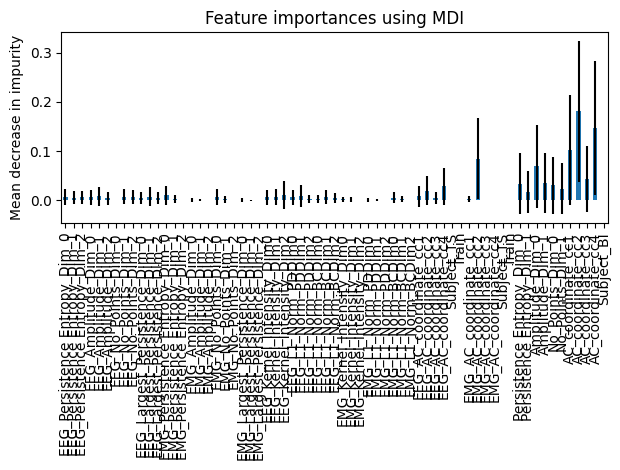

In [225]:
feature_indices = np.arange(0,65)
#feature_indices = np.arange(20,40)
#feature_indices = np.arange(40,60) 
#feature_indices = np.arange(60,80)
#feature_indices = np.arange(80,100)


importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_df.columns)


fig, ax = plt.subplots()
forest_importances[feature_indices].plot.bar(yerr=std[feature_indices], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# Recursive Feature Elimination for Random Forest
from sklearn.feature_selection import RFE

rfe = RFE(rf, n_features_to_select=150)
rfe.fit(X_train, y_train)

y_pred = rfe.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", accuracy)

# Has a negative effect if not all features are selected (with current parameters)

In [25]:
# Pruning features with low feature importance manually
# ...

In [26]:
# XGBoost

In [27]:
""" Does not have an effect
# Scaling for XGBoost

from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with features
# You might want to exclude the target variable if it's included in the DataFrame

# Extract the feature columns
feature_columns = feature_df.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features using the scaler
df_scaled = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_columns)


# Split data frame again (for each label)
train_label_length = int(0.7*(data_length/5))
train_data_length = train_label_length*5

test_label_length = int(0.7*(data_length/5))+1
test_data_length = test_label_length*5

X_train = pd.DataFrame()
y_train = []

X_test = pd.DataFrame()
y_test = []

for label_idx in range(5):
    X_train = pd.concat([X_train, df_scaled[train_label_length*label_idx:train_label_length*(label_idx+1)]], ignore_index=True)
    y_train.extend(labels[train_label_length*label_idx:train_label_length*(label_idx+1)])

    X_test = pd.concat([X_test, df_scaled[train_label_length+test_label_length*label_idx:train_label_length+test_label_length*(label_idx+1)]])
    y_test.extend(labels[train_label_length+test_label_length*label_idx:train_label_length+test_label_length*(label_idx+1)])

""" 

" Does not have an effect\n# Scaling for XGBoost\n\nfrom sklearn.preprocessing import StandardScaler\n\n# Assuming df is your DataFrame with features\n# You might want to exclude the target variable if it's included in the DataFrame\n\n# Extract the feature columns\nfeature_columns = feature_df.columns\n\n# Initialize the StandardScaler\nscaler = StandardScaler()\n\n# Fit and transform the features using the scaler\ndf_scaled = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_columns)\n\n\n# Split data frame again (for each label)\ntrain_label_length = int(0.7*(data_length/5))\ntrain_data_length = train_label_length*5\n\ntest_label_length = int(0.7*(data_length/5))+1\ntest_data_length = test_label_length*5\n\nX_train = pd.DataFrame()\ny_train = []\n\nX_test = pd.DataFrame()\ny_test = []\n\nfor label_idx in range(5):\n    X_train = pd.concat([X_train, df_scaled[train_label_length*label_idx:train_label_length*(label_idx+1)]], ignore_index=True)\n    y_train.extend(labels[tr

In [174]:
model = xgb.XGBClassifier()

#Training the model on the training data
model.fit(X_train._get_numeric_data(), y_train)

#Making predictions on the test set
predictions = model.predict(X_test._get_numeric_data())

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)

Accuracy: 0.6782608695652174
